In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import os
import re
from fuzzywuzzy import process
import warnings
warnings.filterwarnings('ignore')

In [54]:
%load_ext autoreload
%autoreload 2
from funciones.funciones import check_df
from funciones.funciones import identificacion_valores_problem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Análisis de los datos de campañas de marketing de una empresa Fintech para
conseguir identificar patrones, tendencias y factores que influyen en que un
cliente acabe contratando un depósito. Tras un análisis exhaustivo de todos sus
datos, habrá que implementar un modelo simple que ayude a entender y predecir
la efectividad de las campañas de marketing, y diseñar un dashboard para la
capa ejecutiva de la fintech con los principales insights y KPIs de los resultados
de las campañas.

In [55]:
os.getcwd()

'c:\\Users\\Arnau\\OneDrive\\Documentos\\GitHub\\data-analytics-tfm'

In [56]:
df = pd.read_excel('bank-additional_bank-additional-full.xlsx')

# **1. Análisis de datos: Índice (PDF)**


- Entendimiento de datos de clientes, de los detalles de las
campañas y sus resultados
- Estadísticas descriptivas para entender las características básicas
de los datos.
- Análisis de la relación entre características demográficas del
cliente (edad, trabajo, educación) y la suscripción a un depósito a
plazo.
- Evaluación del impacto de los detalles de la campaña (número de
contactos, mes, día de la semana) en el resultado de la campaña.

Cada punto de ahora en adelante es un punto del guión del trabajo

## **1.1. Entendimiento de datos de clientes**

### **Datos del cliente**

* **age:** Edad

* **job:** Profesión (admin, blue-collar, technician, etc.)

* **marital:** Estado civil (married, single, divorced)

* **education:** Nivel de estudios

* **default:** ¿Ha tenido impagos de crédito? (yes/no/unknown)

* **housing:** ¿Tiene hipoteca? (yes/no/unknown)

* **loan:** ¿Tiene préstamo personal? (yes/no/unknown)


### **Datos de la campaña actual**

* **contact:** Tipo de contacto (cellular/telephone)

* **month:** Mes del último contacto

* **day_of_week:** Día de la semana del último contacto

* **duration:** Duración de la llamada en segundos

* **campaign:** Número de contactos realizados en esta campaña para este cliente


### **Datos de campañas anteriores**

* **pdays:** Días desde el último contacto de una campaña anterior (999 = nunca contactado antes)

* **previous:** Número de contactos en campañas anteriores

* **poutcome:** Resultado de la campaña anterior (success/failure/nonexistent)


### **Datos de indicadores macroeconómicos**

* **emp.var.rate (Employment Variation Rate):**  Tasa de variación del empleo. Mide el cambio porcentual en el nivel de empleo respecto al trimestre anterior. Un valor negativo indica destrucción de empleo, positivo indica creación.

* **cons.price.idx (Consumer Price Index):**   Índice de precios al consumo. Básicamente, la inflación. Valores más altos = cosas más caras.

* **cons.conf.idx(Consumer Confidence Index):** Índice de confianza del consumidor. Mide el optimismo/pesimismo de los hogares sobre la economía. Suele oscilar entre -50 y +50 aproximadamente, donde negativo = pesimismo.

* **euribor3m:**  El Euríbor a 3 meses. El tipo de interés al que los bancos europeos se prestan dinero entre sí. Afecta directamente a hipotecas y productos financieros.

* **nr.employed:** Número de empleados (en miles, normalmente). El volumen total de personas empleadas en el país en ese momento.


### **Contratación o no**

* **y**: Sí ha contratado o no el depósito.

___________________________

## 1.2 **Estadísticas descriptivas**

In [57]:
check_df(df)

¿Cuántas filas y columnas hay en el conjunto de datos?
	Hay 41,188 filas y 21 columnas.

########################################################################################
¿Cuáles son las primeras cinco filas del conjunto de datos?


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no



########################################################################################
¿Cuáles son las últimas cinco filas del conjunto de datos?


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,no



########################################################################################
¿Cómo puedes obtener una muestra aleatoria de filas del conjunto de datos?


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
615,41,technician,married,basic.6y,no,yes,no,telephone,may,tue,...,2,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no
31536,44,blue-collar,married,basic.6y,no,no,no,cellular,may,thu,...,4,999,0,nonexistent,-1.8,92893.0,-46.2,1327,5099-01-01 00:00:00,no
37992,30,admin.,single,university.degree,no,no,no,cellular,sep,mon,...,6,999,0,nonexistent,-3.4,92379.0,-29.8,797,5017-05-01 00:00:00,yes
23305,51,technician,married,university.degree,no,yes,no,cellular,aug,wed,...,5,999,0,nonexistent,2026-04-01 00:00:00,93444.0,-36.1,4964,5228-01-01 00:00:00,yes
36679,27,admin.,single,university.degree,no,yes,no,cellular,jun,fri,...,1,999,0,nonexistent,-2.9,92963.0,-40.8,1268,5076-02-01 00:00:00,no



########################################################################################
¿Cuáles son las columnas del conjunto de datos? ¿Cuál es el tipo de datos de cada columna?
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate       object
cons.price.idx    float64
cons.conf.idx     float64
euribor3m          object
nr.employed        object
y                  object
dtype: object

########################################################################################
¿Cuántas columnas hay de cada tipo de datos?
object     14
int64       5
float64     2
Name: count, dtype: int64

#######################################################

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,85401.579955,-40.502600
std,10.42125,259.279249,2.770014,186.910907,0.494901,26471.506796,4.628198
min,17.00000,0.000000,1.000000,0.000000,0.000000,93.200000,-50.800000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,92893.000000,-42.700000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,93749.000000,-41.800000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,93994.000000,-36.400000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,94767.000000,-26.900000



########################################################################################
¿Cuáles son las estadísticas descriptivas básicas de las columnas categóricas?


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,emp.var.rate,euribor3m,nr.employed,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,10,315,11,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,2026-04-01 00:00:00,4857,5228-01-01 00:00:00,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,16234,2868,16234,36548


**¿Qué valores tienen las columnas categóricas?**

In [58]:
for campo_categorico in df:
    if df[campo_categorico].dtype == 'object':
        print(campo_categorico)
        print(df[campo_categorico].unique())
        print('______')

job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
______
marital
['married' 'single' 'divorced' 'unknown']
______
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
______
default
['no' 'unknown' 'yes']
______
housing
['no' 'yes' 'unknown']
______
loan
['no' 'yes' 'unknown']
______
contact
['telephone' 'cellular']
______
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
______
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
______
poutcome
['nonexistent' 'failure' 'success']
______
emp.var.rate
[datetime.datetime(2026, 1, 1, 0, 0) datetime.datetime(2026, 4, 1, 0, 0)
 '-0.1' '-0.2' '-1.8' '-2.9' '-3.4' -3 '-1.7' '-1.1']
______
euribor3m
[4857 4856 4855 4859 '4.86' 4858 4864 4865 4866 4967 4961 4959 4958 '4.96'
 4962 4955 4947 4956 4966 4963 4957 4968 '4.97' 4965 4964 5045 5 4936 4921
 4918 4912 482

**¿Qué valores tienen las columnas numéricas?**

In [59]:
for campo_numerico in df:
    if df[campo_numerico].dtype in ['int64', 'float64']:
        print(campo_numerico)
        print(df[campo_numerico].unique())
        print('______')

age
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
______
duration
[ 261  149  226 ... 1246 1556 1868]
______
campaign
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]
______
pdays
[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]
______
previous
[0 1 2 3 4 5 6 7]
______
cons.price.idx
[9.3994e+04 9.4465e+04 9.3918e+04 9.3444e+04 9.3798e+04 9.3200e+01
 9.2756e+04 9.2843e+04 9.3075e+04 9.2893e+04 9.2963e+04 9.2469e+04
 9.2201e+04 9.2379e+04 9.2431e+04 9.2649e+04 9.2713e+04 9.3369e+04
 9.3749e+04 9.3876e+04 9.4055e+04 9.4215e+04 9.4027e+04 9.4199e+04
 9.4601e+04 9.4767e+04]
______
cons.conf.idx
[-36.4 -41.8 -42.7 -36.1 -40.4 -42.  -45.9 -50.  -47.1 -46.2 -40.8 

________________________________

## **1.3. Limpieza de datos**

Vemos que hay bastantes campos que renombrar, tipos de datos que hay que cambiar y datos erróneos. Analizamos primero qué tendríamos que revisar a primera vista.

### **1.3.1. Campos a limpiar**


- **Ordenar**
    - Month
    - Day
    - Education
- **Reformatear**
    - Valores
        - Education
            - ¿Cambiamos los valores?
        - Día
            - Nombre completo y en primera mayuscula
        - Job
        - emp.var.rate
            - Hay mezcla de fechas, ints y floats
            - Debería ser float

      ~~- nr.employed~~
            ~~- Está en formato fecha~~
            ~~-Tendría que ser int~~
            


**Preguntas al profe**

- El 95% de los clientes no tuvieron contacto previo, y tienen el valor 999. ¿Qué hacemos con él?

_____________________________________________________________________________________________________________

### **1.3.2. Valores problemáticos**

#### **1.3.2.1. Nulos y Outliers**

In [60]:
identificacion_valores_problem(df)

###################################################################################
3.1.1. Proporción de NULOS en cada una de las columnas del conjunto de datos:
age               0.0
campaign          0.0
nr.employed       0.0
euribor3m         0.0
cons.conf.idx     0.0
cons.price.idx    0.0
emp.var.rate      0.0
poutcome          0.0
previous          0.0
pdays             0.0
duration          0.0
job               0.0
day_of_week       0.0
month             0.0
contact           0.0
loan              0.0
housing           0.0
default           0.0
education         0.0
marital           0.0
y                 0.0
dtype: float64
###################################################################################
3.1.2. Número de DUPLICADOS totales: 12
###################################################################################
3.1.3. Columnas numéricas con OUTLIERS
Número de outliers en la columna "age": 469
Número de outliers en la columna "duration": 2963
Número de outliers e

#### **1.3.2.2. Duplicados**

¿Cuántos duplicados hay?

In [61]:
df.duplicated().sum()

np.int64(12)

¿Dónde están los duplicados?

In [62]:
df[df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4855,5191,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4855,5191,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4966,5228-01-01 00:00:00,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4966,5228-01-01 00:00:00,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4962,5228-01-01 00:00:00,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4962,5228-01-01 00:00:00,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4962,5228-01-01 00:00:00,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4962,5228-01-01 00:00:00,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4968,5228-01-01 00:00:00,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4968,5228-01-01 00:00:00,no


### **1.3.3. Limpieza**

#### **1.3.3.1. Renombrar campos**

Renombramos columnas y llamamos al df "df_clean"

In [63]:
df_clean = df.copy()
df_clean = df_clean.rename(columns={'y':'result',
                                    'pdays':'days_last_contact',
                                    'emp.var.rate':'employment_variation_rate',
                                    'previous':'number_previous_contacts',
                                    'nr.employed':'nr_employed',
                                    'housing':'mortgage',
                                    'default':'credit_default',
                                    'campaign':'number_of_contacts',
                                    'cons.conf.idx':'cons_conf_idx',
                                    'cons.price.idx':'cons_price_idx'})
df_clean.columns

Index(['age', 'job', 'marital', 'education', 'credit_default', 'mortgage',
       'loan', 'contact', 'month', 'day_of_week', 'duration',
       'number_of_contacts', 'days_last_contact', 'number_previous_contacts',
       'poutcome', 'employment_variation_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'result'],
      dtype='object')

In [64]:
orden_meses = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df_clean['month'] = pd.Categorical(df_clean['month'], categories=orden_meses, ordered=True)

#### **1.3.3.2. Limpieza de duplicados**

Solo hay 24 registros duplicados, no afecta a la muestra total. Yo los dropearía.

In [65]:
df_clean = df_clean.drop_duplicates(keep='first')

In [66]:
df_clean.duplicated().sum()

np.int64(0)

#### **1.3.3.3. Limpieza de nulos**

In [67]:
df_clean.isna().sum()

age                          0
job                          0
marital                      0
education                    0
credit_default               0
mortgage                     0
loan                         0
contact                      0
month                        0
day_of_week                  0
duration                     0
number_of_contacts           0
days_last_contact            0
number_previous_contacts     0
poutcome                     0
employment_variation_rate    0
cons_price_idx               0
cons_conf_idx                0
euribor3m                    0
nr_employed                  0
result                       0
dtype: int64

In [68]:
df_clean[['credit_default', 'mortgage', 'loan']].apply(pd.Series.value_counts)

# Tratando unknown como nulos

,credit_default,mortgage,loan
no,32577,18615,33938
unknown,8596,990,990
yes,3,21571,6248


Los 'nulos' de hipoteca y prestamo no me parecen relevantes pero los de credit_default me parecen muchos, quito solo los pequeños

In [69]:
# Ostras pero es nulo que da información... no sé si los dropearía. 

In [70]:
df_clean = df_clean[(df_clean['mortgage'] != 'unknown') & (df_clean['loan'] != 'unknown')]

#### **1.3.3.4. Cambiar tipos de datos**

**nr_employed**

Investigando un poco, parece que este dataset es de un banco portugués. Tiene sentido que la data de este campo sea en millones, en un float, de tres decimales. Tendremos esto en cuenta a la hora de transformar los datetime que tiene este campo, dado que el año es similar al unico valor int que hay, que es 5191, que sería realmente 5.19 millones de empleados. Lo comprobamos aquí debajo.


In [71]:
df['nr.employed'].unique()

array([5191, datetime.datetime(5228, 1, 1, 0, 0),
       datetime.datetime(5195, 8, 1, 0, 0),
       datetime.datetime(5176, 3, 1, 0, 0),
       datetime.datetime(5099, 1, 1, 0, 0),
       datetime.datetime(5076, 2, 1, 0, 0),
       datetime.datetime(5017, 5, 1, 0, 0),
       datetime.datetime(5023, 5, 1, 0, 0),
       datetime.datetime(5008, 7, 1, 0, 0),
       datetime.datetime(4991, 6, 1, 0, 0),
       datetime.datetime(4963, 6, 1, 0, 0)], dtype=object)

Procesamos los datetime para convertirlos a integer.


In [72]:
mask = df_clean['nr_employed'].apply(lambda x: 'datetime' in str(type(x)))
# Obtiene una lista de True/False sobre si los registros contienen "datetime" en su type.


df_clean.loc[mask, 'nr_employed'] = df_clean.loc[mask, 'nr_employed'].apply(lambda x: x.year)
# A los registros de la columna nr_employed que cumplen las condiciones de la variable anterior, se les aplicará la extracción del año, y se introducirá en esos mismos registros.

df_clean['nr_employed'] = df_clean['nr_employed'].astype(float).round(2)


**employment_variation_rate**

Revisamos que en este campo hay mucha variedad de formatos. 

In [73]:
df_clean['employment_variation_rate'].unique()

array([datetime.datetime(2026, 1, 1, 0, 0),
       datetime.datetime(2026, 4, 1, 0, 0), '-0.1', '-0.2', '-1.8',
       '-2.9', '-3.4', -3, '-1.7', '-1.1'], dtype=object)

¿Cuántos hay de cada uno?

In [74]:
df_clean['employment_variation_rate'].apply(type).value_counts()

employment_variation_rate
<class 'datetime.datetime'>    23386
<class 'str'>                  16634
<class 'int'>                    166
Name: count, dtype: int64

Se repite el mismo patrón que en el anterior campo. En los datetime, aquí parece que son los meses y los días los que conformarían ese índice (float). 

Como hemos visto arriba, los datetime son la mayoría, por lo que conviene mantenerlos y transformarlos adecuadamente. Mirando la data histórica de la variabilidad de empleo en Portugal en Trading Economics, nunca ha pasado de 4,1 (mes y día), por lo que debería ser 1,4. 

El otro datetime tiene que ser a la fuerza 1,1; lo que tiene sentido con el resto de la data.

In [75]:
df_clean['employment_variation_rate'].value_counts()

employment_variation_rate
2026-04-01 00:00:00    15844
-1.8                    8982
2026-01-01 00:00:00     7542
-0.1                    3615
-2.9                    1612
-3.4                    1045
-1.7                     755
-1.1                     615
-3                       166
-0.2                      10
Name: count, dtype: int64

Por este motivo, identificamos de nuevo los datetimes y los convertimos a float.

In [76]:
mask_2 = df_clean['employment_variation_rate'].apply(lambda x:'datetime' in str(type(x)))
# Identificamos los valores que contengan datetime y los guardamos en una variable.

df_clean.loc[mask_2, 'employment_variation_rate'] = df_clean.loc[mask_2, 'employment_variation_rate'].apply(lambda x:float(f"{x.day}.{x.month}")).astype(float)
# En las filas que cumplan con las condicion y en la columna seleccionada, aplicaremos los siguientes cambios. Extraeremos el día y el mes 
# y los convertiremos en un float, y los insertaremos de nuevo en el lugar en el que estaban.

df_clean['employment_variation_rate'].apply(type).value_counts()

employment_variation_rate
<class 'float'>    23386
<class 'str'>      16634
<class 'int'>        166
Name: count, dtype: int64

Tras contar los tipos de datos, vemos que siguen habiendo string e integers, por lo que toca convertirlos.

In [77]:
df_clean['employment_variation_rate'] = df_clean['employment_variation_rate'].astype(float)

**Euribor**

Limpio la columna de euribor, todo tipo float representado en estilo x.xxx, como debe ser

In [78]:
from funciones.funciones import eur_good
df_clean['euribor3m'] = df_clean['euribor3m'].apply(eur_good)

In [79]:
df_clean['euribor3m'] = df_clean['euribor3m'].map(lambda x: f"{x:.3f}")

In [80]:
df_clean['euribor3m'].astype(float).mean()

np.float64(3.571502339123078)

In [81]:
df_clean

,age,job,marital,education,credit_default,mortgage,loan,contact,month,day_of_week,...,number_of_contacts,days_last_contact,number_previous_contacts,poutcome,employment_variation_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93994.0,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94767.0,-50.8,1.028,4963.0,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94767.0,-50.8,1.028,4963.0,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94767.0,-50.8,1.028,4963.0,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94767.0,-50.8,1.028,4963.0,yes


In [82]:
df_clean.describe()

,age,duration,number_of_contacts,days_last_contact,number_previous_contacts,employment_variation_rate,cons_price_idx,cons_conf_idx,nr_employed
count,40186.000000,40186.000000,40186.000000,40186.000000,40186.000000,40186.000000,40186.000000,40186.000000,40186.000000
mean,40.025581,258.515876,2.568059,962.404892,0.172722,0.081145,85351.569148,-40.508127,5166.862241
std,10.421759,259.413816,2.765787,187.084504,0.494140,1.570467,26542.043628,4.629310,72.305208
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,93.200000,-50.800000,4963.000000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,92893.000000,-42.700000,5099.000000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93749.000000,-41.800000,5191.000000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93994.000000,-36.400000,5228.000000
max,98.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94767.000000,-26.900000,5228.000000


#### **1.3.3.5. Limpieza de outliers**

In [ ]:
df_clean['duration']

Los mantenemos, pero creamos una tabla nueva para cuando haya que visualizar datos no haya datos disonantes.

In [83]:
identificacion_valores_problem(df_clean)

###################################################################################
3.1.1. Proporción de NULOS en cada una de las columnas del conjunto de datos:
age                          0.0
number_of_contacts           0.0
nr_employed                  0.0
euribor3m                    0.0
cons_conf_idx                0.0
cons_price_idx               0.0
employment_variation_rate    0.0
poutcome                     0.0
number_previous_contacts     0.0
days_last_contact            0.0
duration                     0.0
job                          0.0
day_of_week                  0.0
month                        0.0
contact                      0.0
loan                         0.0
mortgage                     0.0
credit_default               0.0
education                    0.0
marital                      0.0
result                       0.0
dtype: float64
###################################################################################
3.1.2. Número de DUPLICADOS totales: 0
#######

Creamos la tabla dentro del rango intercuartilico

In [84]:
df_clean_no_outliers = df_clean.copy()

for col in df_clean_no_outliers.select_dtypes(include='number').columns:
    Q1 = df_clean_no_outliers[col].quantile(0.25)
    Q3 = df_clean_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    df_clean_no_outliers = df_clean_no_outliers[(df_clean_no_outliers[col] >= Q1 - 1.5 * IQR) & (df_clean_no_outliers[col] <= Q3 + 1.5 * IQR)]

Comprobamos que hemos eliminado los outliers

In [85]:
identificacion_valores_problem(df_clean_no_outliers) # Ojo que los datos que no estén transformados a numérico no los quita de outliers.

###################################################################################
3.1.1. Proporción de NULOS en cada una de las columnas del conjunto de datos:
age                          0.0
number_of_contacts           0.0
nr_employed                  0.0
euribor3m                    0.0
cons_conf_idx                0.0
cons_price_idx               0.0
employment_variation_rate    0.0
poutcome                     0.0
number_previous_contacts     0.0
days_last_contact            0.0
duration                     0.0
job                          0.0
day_of_week                  0.0
month                        0.0
contact                      0.0
loan                         0.0
mortgage                     0.0
credit_default               0.0
education                    0.0
marital                      0.0
result                       0.0
dtype: float64
###################################################################################
3.1.2. Número de DUPLICADOS totales: 0
#######

## 1.4. **Análisis de la relación entre características demográficas del cliente (edad, trabajo, educación) y la suscripción a un depósito a plazo.**

In [86]:
df_clean.columns


Index(['age', 'job', 'marital', 'education', 'credit_default', 'mortgage',
       'loan', 'contact', 'month', 'day_of_week', 'duration',
       'number_of_contacts', 'days_last_contact', 'number_previous_contacts',
       'poutcome', 'employment_variation_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'result'],
      dtype='object')

In [87]:
df_clean['job'][0]

'housemaid'

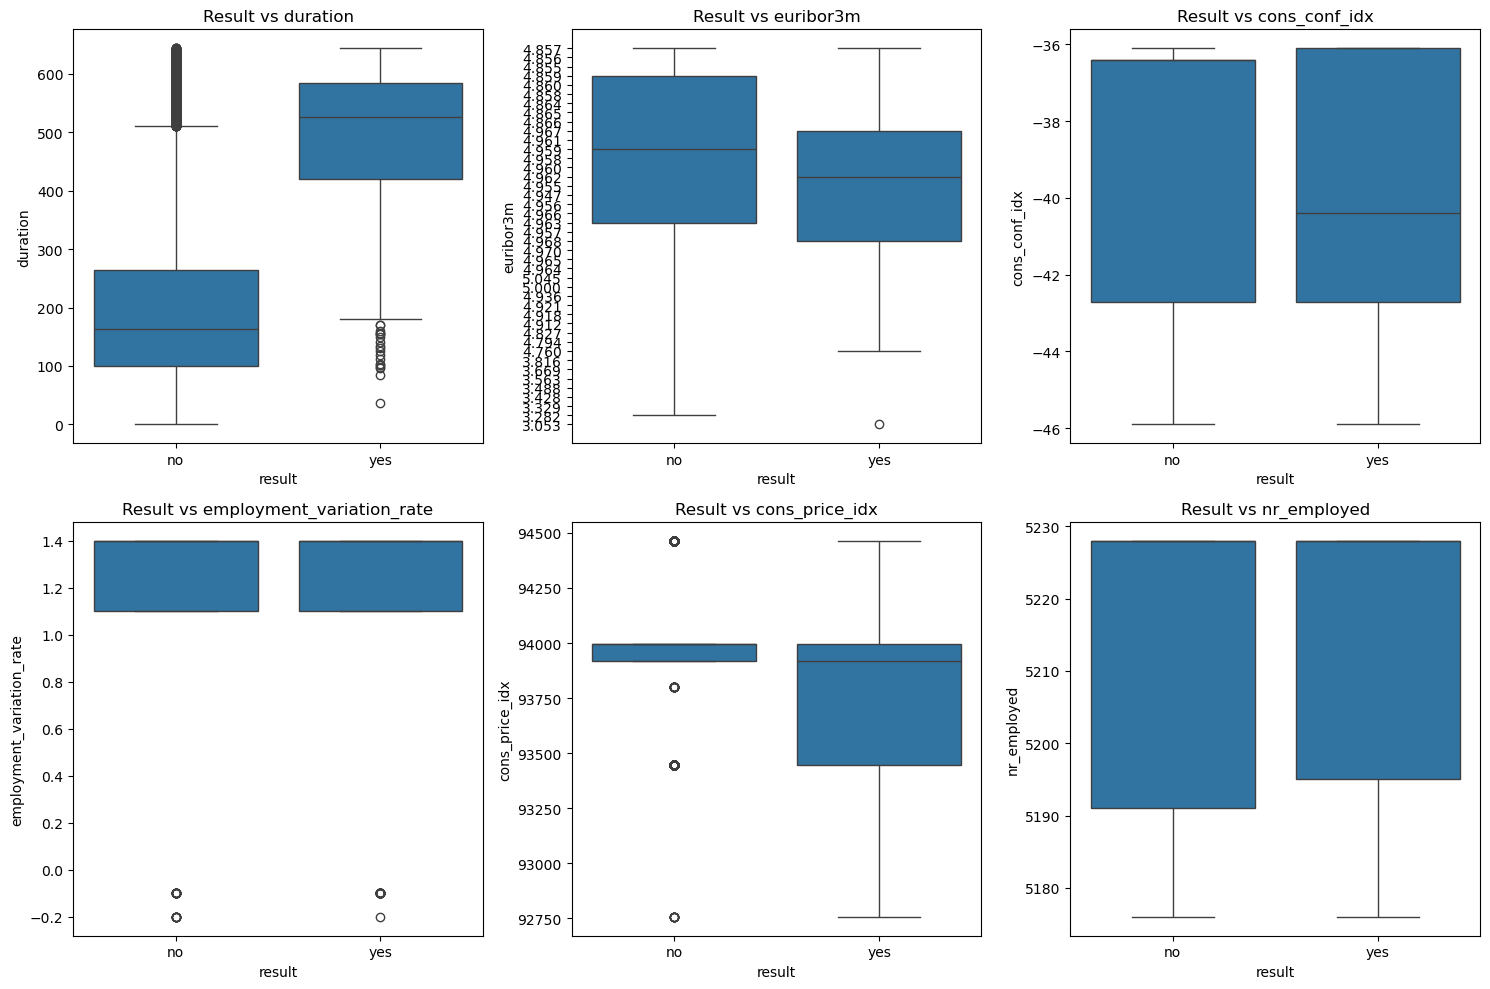

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

cols_numericas = ['duration', 'euribor3m', 'cons_conf_idx', 
                  'employment_variation_rate', 'cons_price_idx', 'nr_employed']

for ax, col in zip(axes.flatten(), cols_numericas):
    sns.boxplot(data=df_clean_no_outliers, x='result', y=col, ax=ax)
    ax.set_title(f'Result vs {col}')

plt.tight_layout()
plt.show()

#### **Edad**


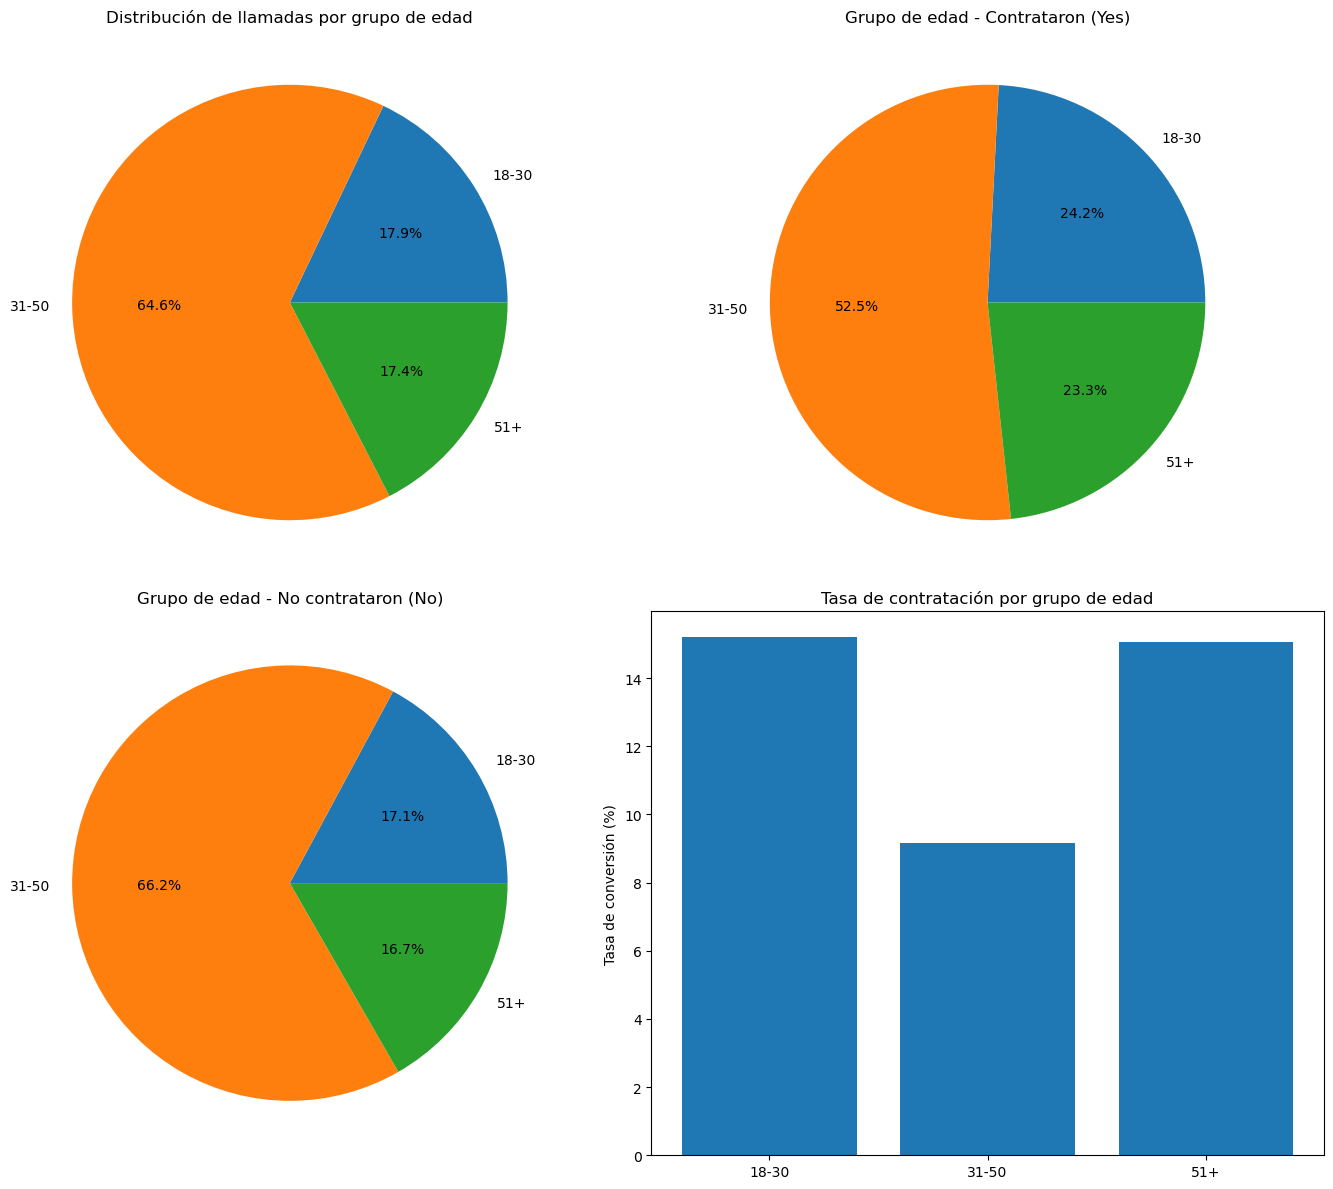

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear grupos de edad
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 30, 50, 100], 
                                labels=['18-30', '31-50', '51+'])

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Pie distribución total de llamadas
age_counts = df_clean['age_group'].value_counts().sort_index()
axes[0, 0].pie(age_counts, labels=age_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Distribución de llamadas por grupo de edad')

# Pie para los que contrataron (yes)
yes_data = df_clean[df_clean['result'] == 'yes']['age_group'].value_counts().sort_index()
axes[0, 1].pie(yes_data, labels=yes_data.index, autopct='%1.1f%%')
axes[0, 1].set_title('Grupo de edad - Contrataron (Yes)')

# Pie para los que no contrataron (no)
no_data = df_clean[df_clean['result'] == 'no']['age_group'].value_counts().sort_index()
axes[1, 0].pie(no_data, labels=no_data.index, autopct='%1.1f%%')
axes[1, 0].set_title('Grupo de edad - No contrataron (No)')

# Tasa de conversión por grupo de edad
conversion = df_clean.groupby('age_group')['result'].apply(lambda x: (x == 'yes').mean() * 100)
axes[1, 1].bar(conversion.index, conversion.values)
axes[1, 1].set_ylabel('Tasa de conversión (%)')
axes[1, 1].set_title('Tasa de contratación por grupo de edad')

plt.tight_layout()
plt.show()

#### **Trabajo**

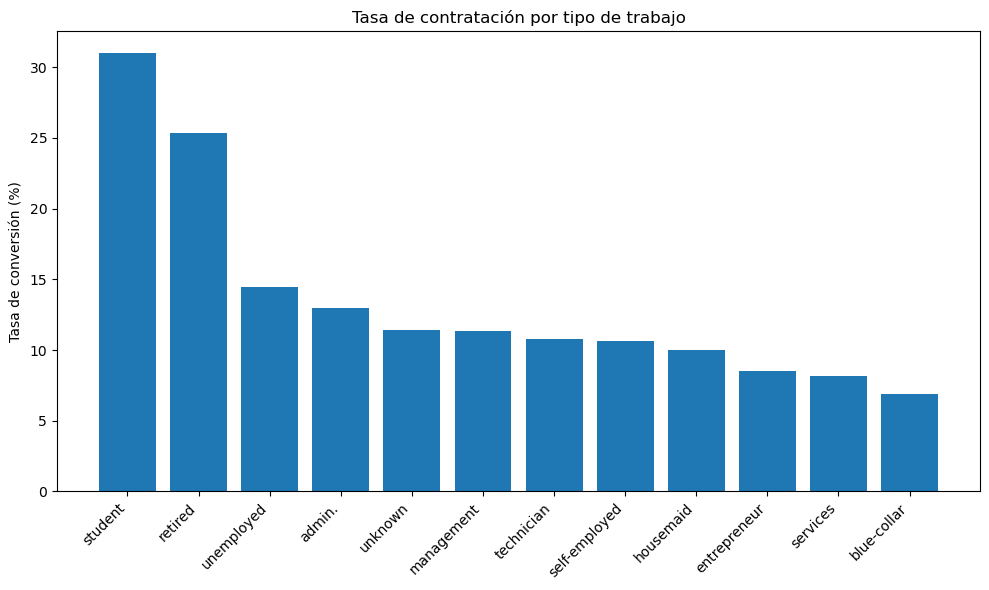

In [90]:
import matplotlib.pyplot as plt

conversion = df_clean.groupby('job')['result'].apply(lambda x: (x == 'yes').mean() * 100)
conversion = conversion.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(conversion.index, conversion.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Tasa de conversión (%)')
plt.title('Tasa de contratación por tipo de trabajo')
plt.tight_layout()
plt.show()

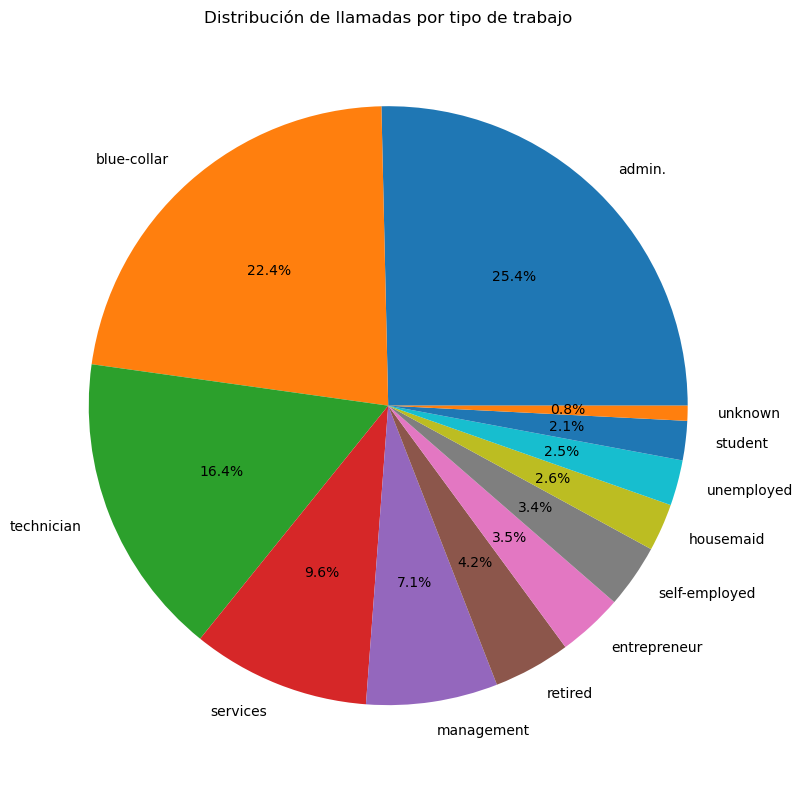

In [91]:
import matplotlib.pyplot as plt

job_counts = df_clean['job'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(job_counts, labels=job_counts.index, autopct='%1.1f%%')
plt.title('Distribución de llamadas por tipo de trabajo')
plt.tight_layout()
plt.show()

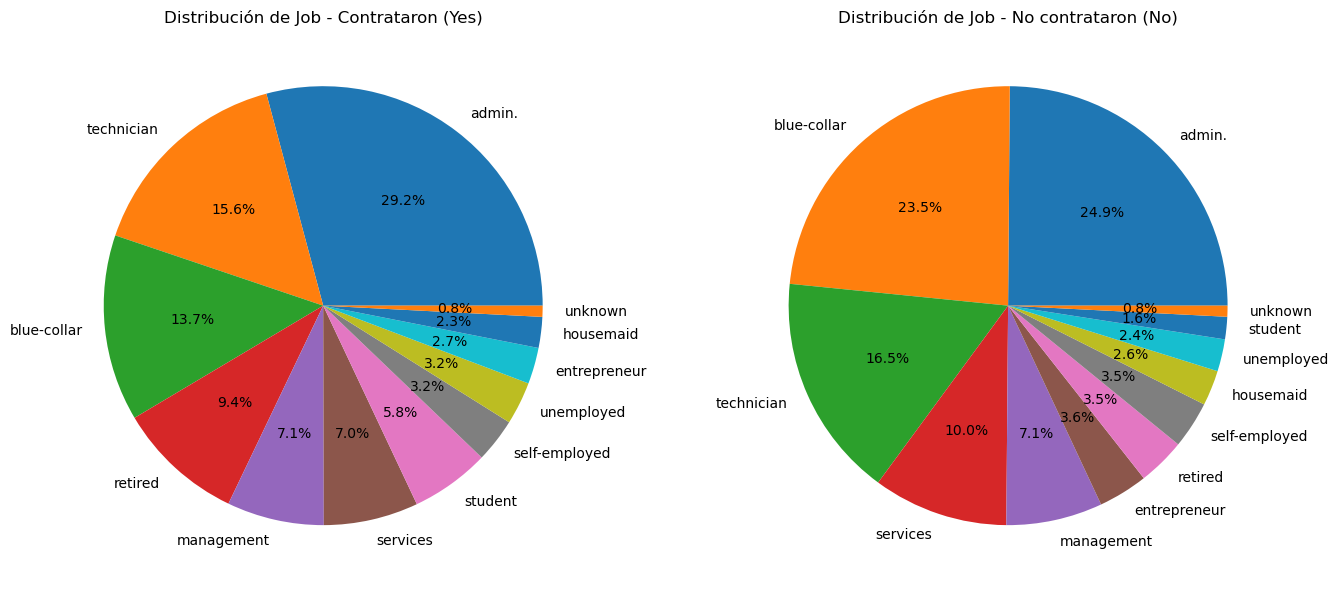

In [92]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie para los que contrataron (yes)
yes_data = df_clean[df_clean['result'] == 'yes']['job'].value_counts()
axes[0].pie(yes_data, labels=yes_data.index, autopct='%1.1f%%')
axes[0].set_title('Distribución de Job - Contrataron (Yes)')

# Pie para los que no contrataron (no)
no_data = df_clean[df_clean['result'] == 'no']['job'].value_counts()
axes[1].pie(no_data, labels=no_data.index, autopct='%1.1f%%')
axes[1].set_title('Distribución de Job - No contrataron (No)')

plt.tight_layout()
plt.show()

#### **Estado civil**

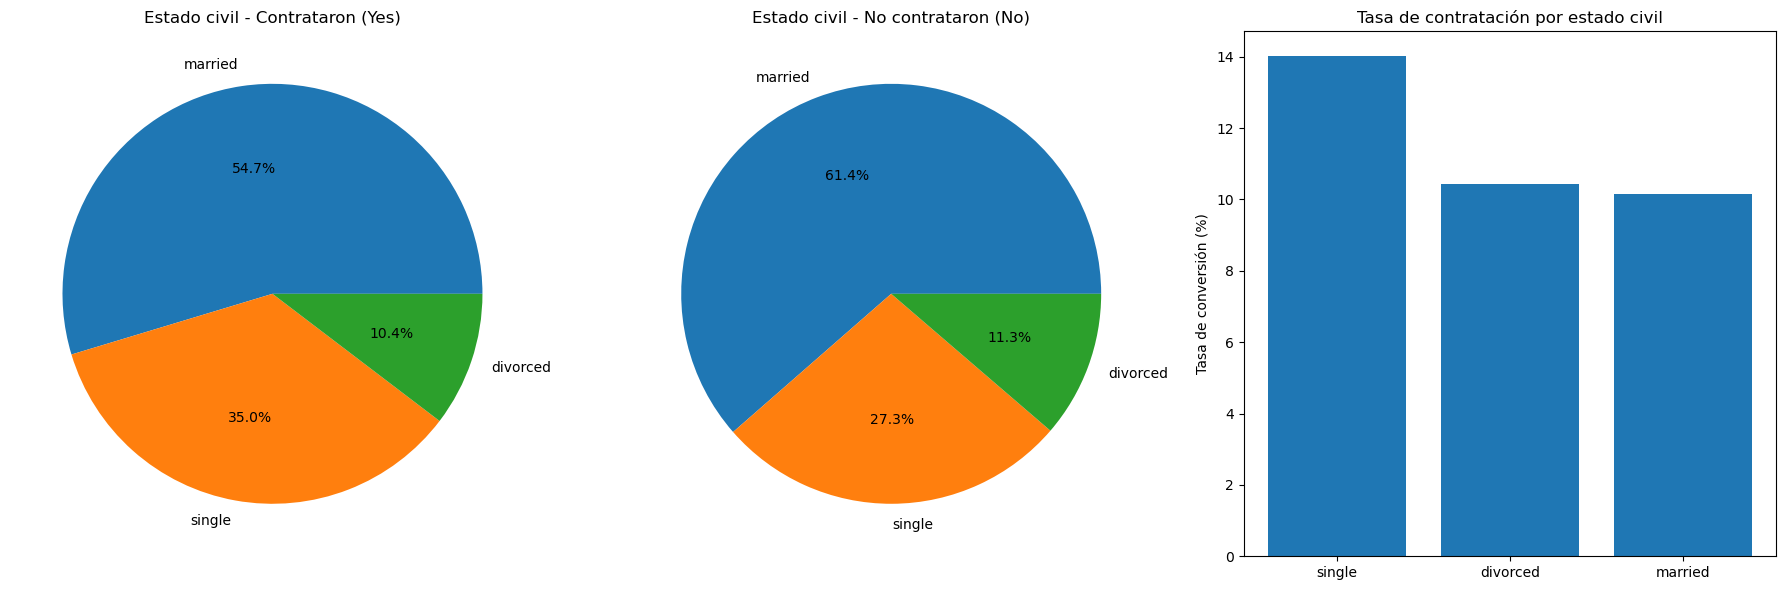

In [93]:
import matplotlib.pyplot as plt

# Filtrar sin unknown
df_marital = df_clean[df_clean['marital'] != 'unknown']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pie para los que contrataron (yes)
yes_data = df_marital[df_marital['result'] == 'yes']['marital'].value_counts()
axes[0].pie(yes_data, labels=yes_data.index, autopct='%1.1f%%')
axes[0].set_title('Estado civil - Contrataron (Yes)')

# Pie para los que no contrataron (no)
no_data = df_marital[df_marital['result'] == 'no']['marital'].value_counts()
axes[1].pie(no_data, labels=no_data.index, autopct='%1.1f%%')
axes[1].set_title('Estado civil - No contrataron (No)')

# Tasa de conversión por estado civil
conversion = df_marital.groupby('marital')['result'].apply(lambda x: (x == 'yes').mean() * 100)
conversion = conversion.sort_values(ascending=False)
axes[2].bar(conversion.index, conversion.values)
axes[2].set_ylabel('Tasa de conversión (%)')
axes[2].set_title('Tasa de contratación por estado civil')

plt.tight_layout()
plt.show()

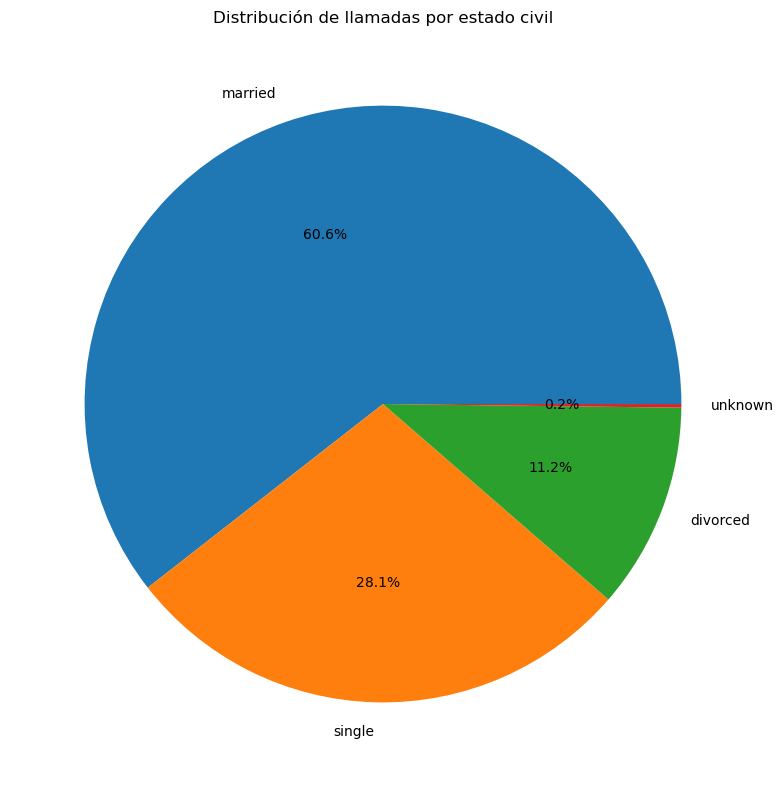

In [94]:
import matplotlib.pyplot as plt

marital_counts = df_clean['marital'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(marital_counts, labels=marital_counts.index, autopct='%1.1f%%')
plt.title('Distribución de llamadas por estado civil')
plt.tight_layout()
plt.show()

#### **Educación**

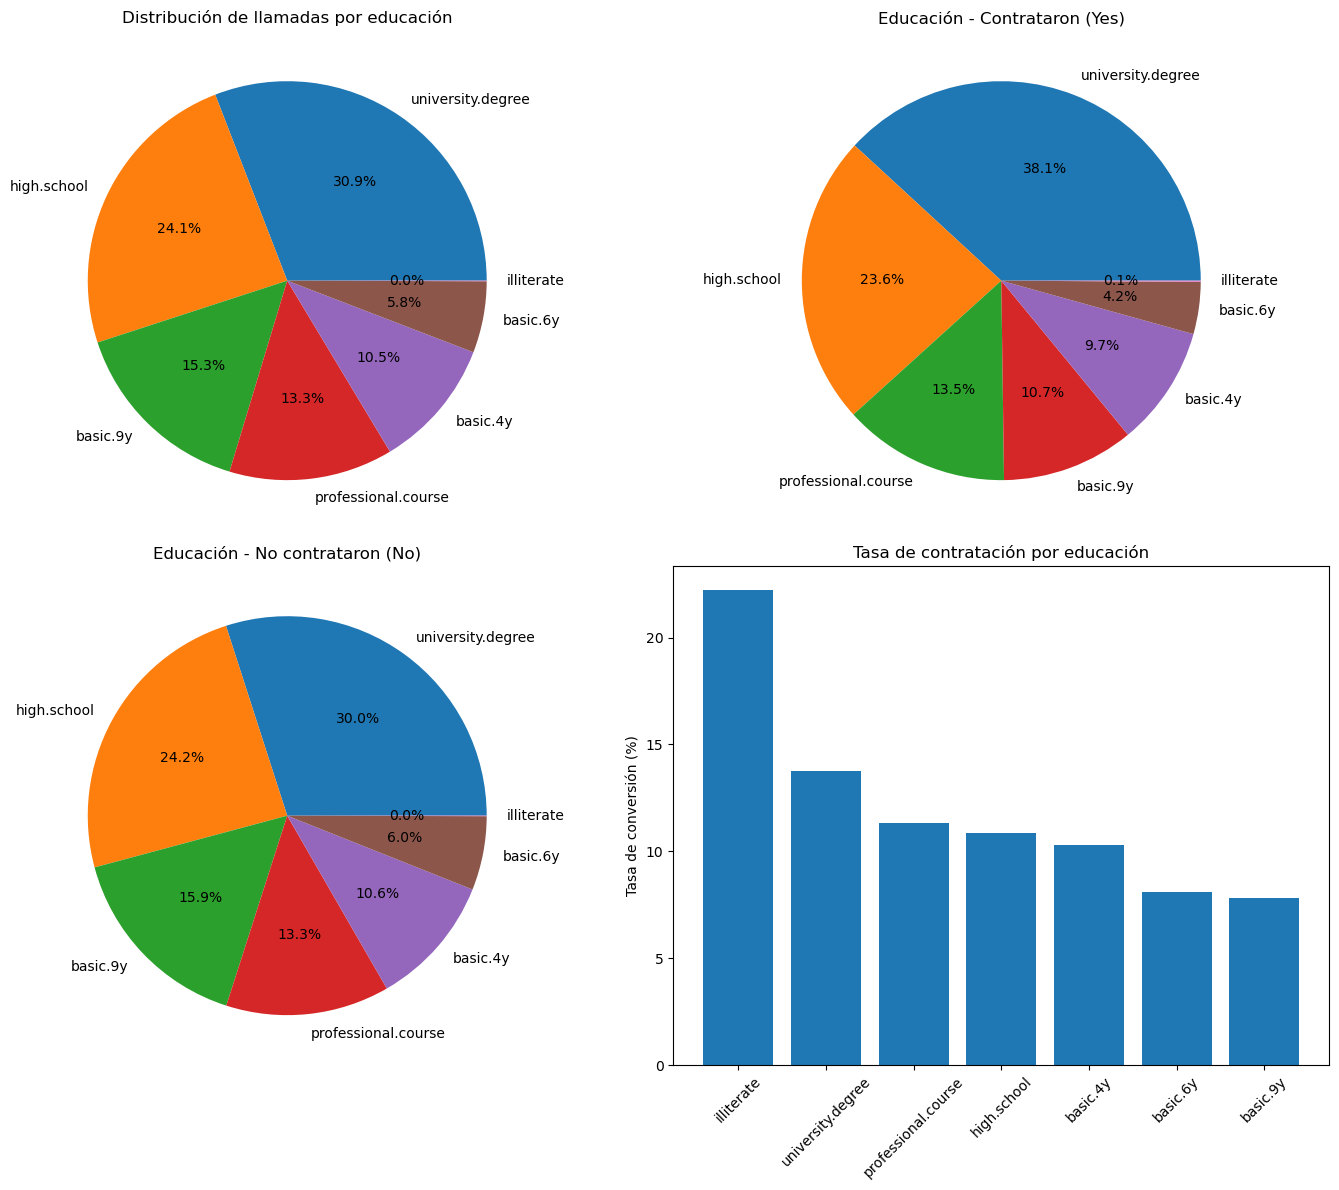

In [95]:
import matplotlib.pyplot as plt

# Filtrar sin unknown
df_education = df_clean[df_clean['education'] != 'unknown']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Pie distribución total de llamadas
edu_counts = df_education['education'].value_counts()
axes[0, 0].pie(edu_counts, labels=edu_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Distribución de llamadas por educación')

# Pie para los que contrataron (yes)
yes_data = df_education[df_education['result'] == 'yes']['education'].value_counts()
axes[0, 1].pie(yes_data, labels=yes_data.index, autopct='%1.1f%%')
axes[0, 1].set_title('Educación - Contrataron (Yes)')

# Pie para los que no contrataron (no)
no_data = df_education[df_education['result'] == 'no']['education'].value_counts()
axes[1, 0].pie(no_data, labels=no_data.index, autopct='%1.1f%%')
axes[1, 0].set_title('Educación - No contrataron (No)')

# Tasa de conversión por educación
conversion = df_education.groupby('education')['result'].apply(lambda x: (x == 'yes').mean() * 100)
conversion = conversion.sort_values(ascending=False)
axes[1, 1].bar(conversion.index, conversion.values)
axes[1, 1].set_ylabel('Tasa de conversión (%)')
axes[1, 1].set_title('Tasa de contratación por educación')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### **Mortgage**

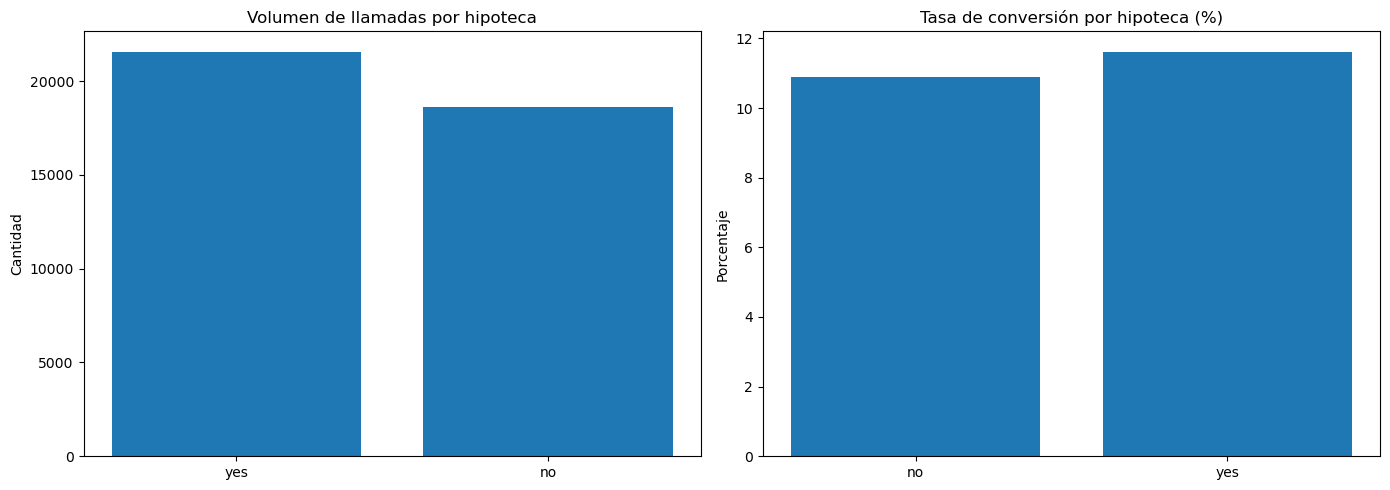

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar sin unknown
df_mortgage = df_clean[df_clean['mortgage'] != 'unknown']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Volumen total por hipoteca
mortgage_counts = df_mortgage['mortgage'].value_counts()
axes[0].bar(mortgage_counts.index, mortgage_counts.values)
axes[0].set_title('Volumen de llamadas por hipoteca')
axes[0].set_ylabel('Cantidad')

# Tasa de conversión por hipoteca
conversion = df_mortgage.groupby('mortgage')['result'].apply(lambda x: (x == 'yes').mean() * 100)
axes[1].bar(conversion.index, conversion.values)
axes[1].set_title('Tasa de conversión por hipoteca (%)')
axes[1].set_ylabel('Porcentaje')

plt.tight_layout()
plt.show()

**loan**

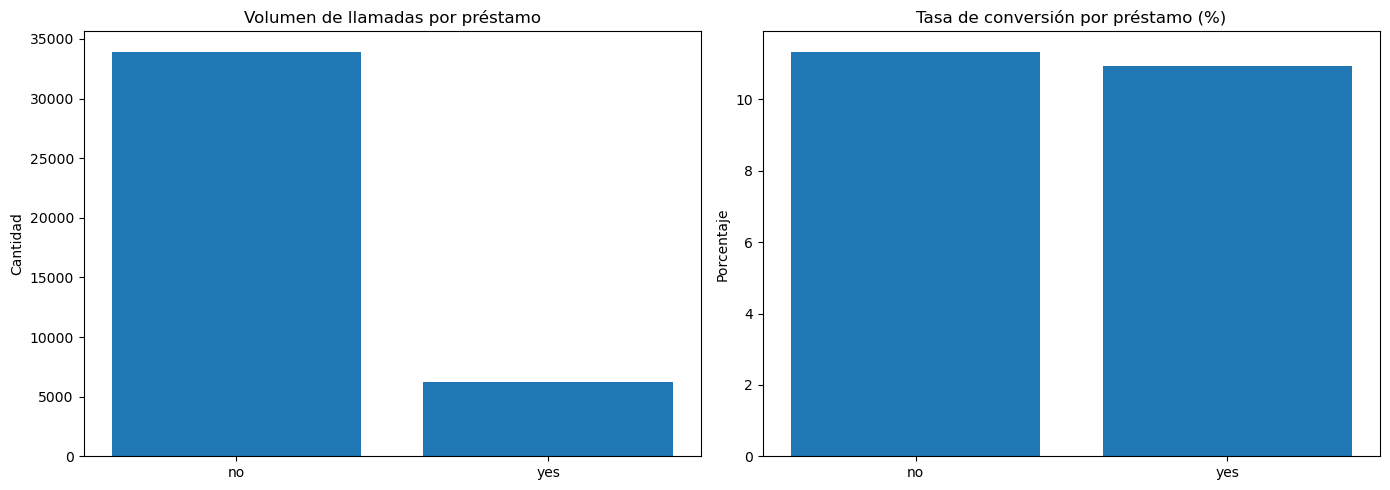

In [97]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar sin unknown
df_loan = df_clean[df_clean['loan'] != 'unknown']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Volumen total por préstamo
loan_counts = df_loan['loan'].value_counts()
axes[0].bar(loan_counts.index, loan_counts.values)
axes[0].set_title('Volumen de llamadas por préstamo')
axes[0].set_ylabel('Cantidad')

# Tasa de conversión por préstamo
conversion = df_loan.groupby('loan')['result'].apply(lambda x: (x == 'yes').mean() * 100)
axes[1].bar(conversion.index, conversion.values)
axes[1].set_title('Tasa de conversión por préstamo (%)')
axes[1].set_ylabel('Porcentaje')

plt.tight_layout()
plt.show()

**default**

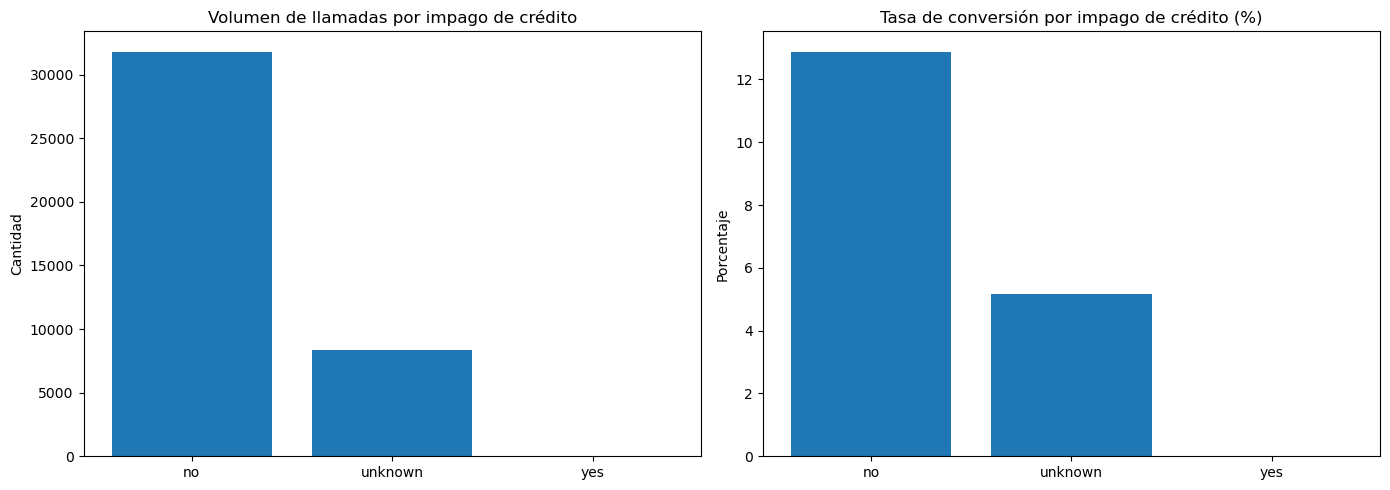

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Volumen total por credit_default
credit_counts = df_clean['credit_default'].value_counts()
axes[0].bar(credit_counts.index, credit_counts.values)
axes[0].set_title('Volumen de llamadas por impago de crédito')
axes[0].set_ylabel('Cantidad')

# Tasa de conversión por credit_default
conversion = df_clean.groupby('credit_default')['result'].apply(lambda x: (x == 'yes').mean() * 100)
axes[1].bar(conversion.index, conversion.values)
axes[1].set_title('Tasa de conversión por impago de crédito (%)')
axes[1].set_ylabel('Porcentaje')

plt.tight_layout()
plt.show()

## **1.5. Evaluación del impacto de los detalles de la campaña (número de contactos, mes, día de la semana) en el resultado de la campaña.**

**¿Cuál es la proporción de los usuarios que contrataron un depósito?**

In [99]:
df_yes_no = df_clean['result'].value_counts(normalize=True)*100

df_yes_no

result
no     88.722441
yes    11.277559
Name: proportion, dtype: float64

<Axes: ylabel='count'>

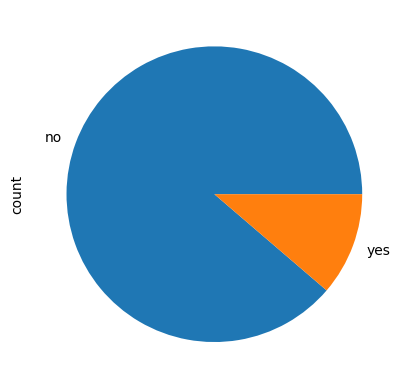

In [100]:
df_clean['result'].value_counts().plot.pie()

**¿Cuál es la distribución de las llamadas en meses?**

<Axes: xlabel='month', ylabel='count'>

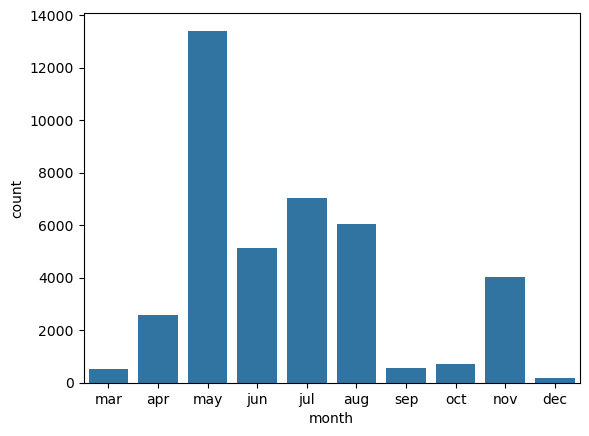

In [103]:
orden_meses = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

sns.countplot(data=df_clean, x='month', order=orden_meses)

**¿Cuántas veces se contacta al cliente? Distribución**

<Axes: xlabel='campaign', ylabel='Count'>

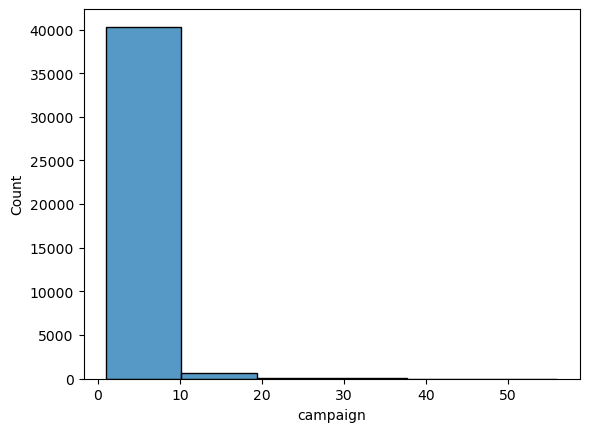

In [102]:
sns.histplot(df['campaign'], bins=6)

**¿Existe correlación entre la contratación del plazo y el euribor?**